In [1]:
import pandas as pd
import glob

files = [i for i in glob.glob(r'/workspaces/miniconda/PKdata/data/*.csv') if 'nca' not in i]

In [2]:

for f_idx, f in enumerate(files):
    if f_idx == 0:
        df_out = pd.read_csv(f)
        df_out = df_out[[i for i in df_out.columns if 'unnamed' not in i.lower()]]
        df_out['TIME'] = df_out['TIME'].astype(float)
    else:
        tmp = pd.read_csv(f)
        tmp = tmp[[i for i in tmp.columns if 'unnamed' not in i.lower()]]
        if 'TIME' in tmp.columns:
            tmp['TIME'] = df_out['TIME'].astype(float)
            merge_c = ['ID', 'TIME']
        else:
            merge_c = ['ID']
        df_out = df_out.merge(tmp, how = 'left', on = merge_c)
        

In [3]:
import numpy as np
from nca import estimate_subject_slope_cv, estimate_k_halflife
xth_df = df_out.loc[df_out['ANALYTE'] == 'xanthohumol', :].copy()


In [4]:
xth_df

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex
0,L1,0.00,0,xanthohumol,20.0,oral,M
1,L1,0.25,0,xanthohumol,NaN,NaN,M
2,L1,0.50,0,xanthohumol,NaN,NaN,M
3,L1,1.00,34,xanthohumol,NaN,NaN,M
4,L1,1.50,15,xanthohumol,NaN,NaN,M
...,...,...,...,...,...,...,...
1101,H17,24.00,6,xanthohumol,NaN,NaN,M
1102,H17,48.00,0,xanthohumol,NaN,NaN,M
1103,H17,72.00,0,xanthohumol,NaN,NaN,M
1104,H17,96.00,0,xanthohumol,NaN,NaN,M


In [5]:
tmp_df = pd.DataFrame({
    'ID':np.repeat('P1', 10), 
    'TIME':[0,1,2,3,4,6,9,12,18,24],
    'CONC':[8,7.09, 6.29, 5.58, 4.95, 3.89, 2.71, 1.89, 0.92, 0.44]
})
tmp_df2 = pd.DataFrame({
    'ID':np.repeat('P2', 10), 
    'TIME':[0,1,2,3,4,6,9,12,18,24],
    'CONC':[0, 12.18, 14.12, 13.43, 12.16, 9.64, 6.73, 4.69, 2.28, 1.11]
})
tmp_df = pd.concat([tmp_df, tmp_df2])

tmp_df['CONC_ln'] = np.log(tmp_df['CONC'])

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
tmp_df

,ID,TIME,CONC,CONC_ln
0,P1,0,8.00,2.079442
1,P1,1,7.09,1.958685
2,P1,2,6.29,1.838961
3,P1,3,5.58,1.719189
4,P1,4,4.95,1.599388
5,P1,6,3.89,1.358409
6,P1,9,2.71,0.996949
7,P1,12,1.89,0.636577
8,P1,18,0.92,-0.083382
9,P1,24,0.44,-0.820981


<Axes: xlabel='TIME', ylabel='CONC'>

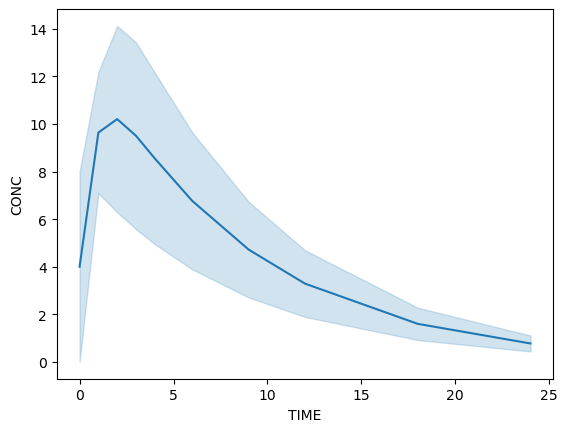

In [7]:
import seaborn as sns
sns.lineplot(tmp_df, x = 'TIME', y = 'CONC')


In [8]:
k_est = (np.log(.92) - np.log(.44)) / (18-24)
k_est

-0.1229331571884632

In [9]:
use_toy_2 = False
if use_toy_2:
    xth_df = tmp_df.copy()

In [10]:
xth_df

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex
0,L1,0.00,0,xanthohumol,20.0,oral,M
1,L1,0.25,0,xanthohumol,NaN,NaN,M
2,L1,0.50,0,xanthohumol,NaN,NaN,M
3,L1,1.00,34,xanthohumol,NaN,NaN,M
4,L1,1.50,15,xanthohumol,NaN,NaN,M
...,...,...,...,...,...,...,...
1101,H17,24.00,6,xanthohumol,NaN,NaN,M
1102,H17,48.00,0,xanthohumol,NaN,NaN,M
1103,H17,72.00,0,xanthohumol,NaN,NaN,M
1104,H17,96.00,0,xanthohumol,NaN,NaN,M


# K and Halflife (t_1/2)

In [11]:
from nca import indentify_low_conc_zones2
dfs = []
for sub in xth_df['ID'].unique():
    dfs.append(indentify_low_conc_zones2(xth_df.loc[xth_df['ID'] == sub, :], conc_col='CONC'))

In [12]:
zeros2 = pd.concat(dfs)

In [13]:
tmp_xth = xth_df.merge(zeros2, how = 'left', on = 'ID')

In [14]:
dfs = []
for sub in xth_df['ID'].unique():
    dfs.append(estimate_subject_slope_cv(xth_df.loc[xth_df['ID'] == sub, :], conc_col='CONC'))

/workspaces/miniconda/PK-Analysis/nca.py:41: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:41: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:41: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:41: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:41: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/workspaces/miniconda/PK-Analysis/nca.py:41: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mea

In [15]:
look = [i for i in dfs if 'H2' in i['ID'].values][0]

In [16]:
from nca import identify_low_conc_zones


zero_starts = identify_low_conc_zones(dfs, low_frac=.005)

In [17]:
zero_starts['zero_window_time_start'].values == zeros2['zero_window_time_start'].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [18]:
from nca import masked_signed_safe_log

def estimate_k_halflife(dfs, zero_zone_df = None):
    zero_zone_df = identify_low_conc_zones(dfs) if zero_zone_df is None else zero_zone_df
    res = []
    for tmp in dfs:
        #id = tmp['ID'].values[0]
        tmp = tmp.merge(zero_zone_df, how = 'left', on = 'ID')#.copy()
        f1 = tmp['start_time'] < tmp['zero_window_time_start']
        f2 = tmp['end_time'] <= tmp['zero_window_time_start']
        tmp = tmp.loc[f1 & f2, :]
        
        tmp['startidx_endidx_slope_sign'] = np.sign(tmp['slope'])
        start_idx_avg_slope = (tmp
                                          .groupby('start_time')['startidx_endidx_slope_sign']
                                          .mean()
                                          .reset_index()
                                          .rename(columns = {'startidx_endidx_slope_sign':'startidx_avg_slope_sign'})
                                          
                                          )
        tmp = tmp.merge(start_idx_avg_slope, how = 'left', on = 'start_time')
        f3 = tmp['startidx_avg_slope_sign'] == -1
        tmp = tmp.loc[f3, :]
        
        avg_adj_r2 = (tmp
                        .groupby('start_time')['adj_r2']
                        .mean()
                        .reset_index()
                        .rename(columns = {'adj_r2':'startidx_avg_adj_r2'})
                        
                            )
        tmp = tmp.merge(avg_adj_r2, how = 'left', on = 'start_time')
        f = tmp['startidx_avg_adj_r2'] > 0.8
        good_liniearity_df = tmp.loc[f, :]
        if len(good_liniearity_df) > 0:
            tmp = good_liniearity_df.copy()
            f = tmp['startidx_avg_adj_r2'] == tmp['startidx_avg_adj_r2'].max()
            tmp = tmp.loc[f, :].copy()
            f = tmp['end_time'] == tmp['end_time'].max()
            tmp = tmp.loc[f, :].copy()
            

            #out_df['geom_mean_halflife_est'] = np.exp(np.mean(masked_signed_safe_log(out_df['window_halflife_est'])))
            tmp['method'] = 'adj_r2'
            
        if len(good_liniearity_df) == 0:
            max_end = tmp['end_time'].max()
            tmp = tmp.loc[tmp['end_time'] == max_end]
            max_start = tmp['start_time'].max()
            tmp = tmp.loc[tmp['start_time'] == max_start]
            tmp['method'] = 'final_nonzero_section'
            debugging = True
        out_df = tmp.copy()
        out_df['window_k_est'] = -1*out_df['slope'].values
        #out_df['geom_mean_k_est'] = np.exp(np.mean(masked_signed_safe_log(out_df['window_k_est'])))
        out_df['window_halflife_est'] = 0.693/out_df['window_k_est']
        res.append(out_df.copy())
    return pd.concat(res).reset_index(drop = True)

In [19]:
ks = estimate_k_halflife(dfs, zero_zone_df=zero_starts)
# this still needs to be filtered to give one unique value of the geom mean per subject

In [20]:
ks

,ID,auc_per_time,start_time,end_time,slope,startidx_endidx_slope_cv,startidx_endidx_slope_sign,intercept,r_value,adj_r2,...,start_time_mean_abs_cv,start_time_std_mean_cv,auc_per_time_gt_lim,zero_window_time_start,consecutive_zero_windows,startidx_avg_slope_sign,startidx_avg_adj_r2,method,window_k_est,window_halflife_est
0,L1,2.500000,12.0,24.0,-0.149313,NaN,-1.0,3.583519,-1.000000,NaN,...,0.839639,0.227279,1.0,24.0,4,-1.0,NaN,final_nonzero_section,0.149313,4.641248
1,L2,2.000000,48.0,72.0,-0.067060,NaN,-1.0,4.828314,-1.000000,NaN,...,0.411993,0.111242,1.0,72.0,2,-1.0,NaN,final_nonzero_section,0.067060,10.334043
2,L3,2.125000,8.0,24.0,-0.112802,-0.053395,-1.0,2.713778,-0.999686,0.998742,...,0.472666,0.281289,1.0,24.0,4,-1.0,0.998742,adj_r2,0.112802,6.143520
3,L4,7.250000,1.0,2.0,-3.091042,-0.021115,-1.0,6.203390,-0.999715,0.998860,...,0.946215,0.496366,1.0,2.0,8,-1.0,0.998860,adj_r2,3.091042,0.224196
4,L5,3.500000,12.0,24.0,-0.173287,NaN,-1.0,4.158883,-1.000000,NaN,...,0.839639,0.227279,1.0,24.0,4,-1.0,NaN,final_nonzero_section,0.173287,3.999151
5,L6,10.000000,4.0,12.0,-0.380565,-0.403725,-1.0,4.858662,-0.949033,0.801327,...,0.700230,0.247373,1.0,12.0,5,-1.0,0.801327,adj_r2,0.380565,1.820975
6,L7,8.500000,2.0,12.0,-0.273349,-0.699078,-1.0,3.666791,-0.933757,0.807853,...,0.724959,0.124362,1.0,12.0,5,-1.0,0.843148,adj_r2,0.273349,2.535217
7,L8,5.100000,4.0,24.0,-0.154768,-0.244321,-1.0,3.525853,-0.961911,0.887909,...,0.489494,0.226495,1.0,24.0,4,-1.0,0.895333,adj_r2,0.154768,4.477678
8,L9,1.500000,12.0,48.0,-0.039546,-0.245165,-1.0,1.935601,-0.990824,0.963463,...,0.292225,0.067241,1.0,48.0,3,-1.0,0.963463,adj_r2,0.039546,17.523733
9,L10,2.000000,4.0,8.0,-0.402359,NaN,-1.0,3.218876,-1.000000,NaN,...,0.926383,0.391029,1.0,8.0,6,-1.0,NaN,final_nonzero_section,0.402359,1.722340


In [21]:
old_meth = False
if old_meth:
    k_cols = ['ID', 'geom_mean_k_est', 'geom_mean_halflife_est', 'start_time', 'end_time', 'zero_window_time_start']
    ks = ks[k_cols].drop_duplicates().copy()

In [22]:
ks.loc[ks['ID'] == 'H1']

,ID,auc_per_time,start_time,end_time,slope,startidx_endidx_slope_cv,startidx_endidx_slope_sign,intercept,r_value,adj_r2,...,start_time_mean_abs_cv,start_time_std_mean_cv,auc_per_time_gt_lim,zero_window_time_start,consecutive_zero_windows,startidx_avg_slope_sign,startidx_avg_adj_r2,method,window_k_est,window_halflife_est
31,H1,2.5,48.0,96.0,-0.04054,-0.069033,-1.0,3.933706,-0.997232,0.988942,...,0.102672,0.047573,1.0,96.0,1,-1.0,0.988942,adj_r2,0.04054,17.094314


/tmp/ipykernel_93023/301033910.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2)


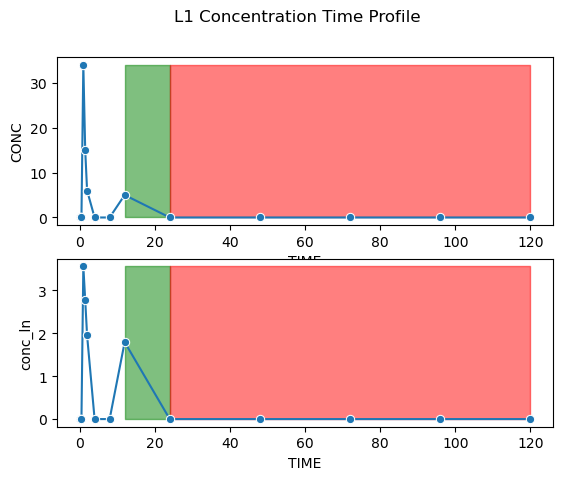

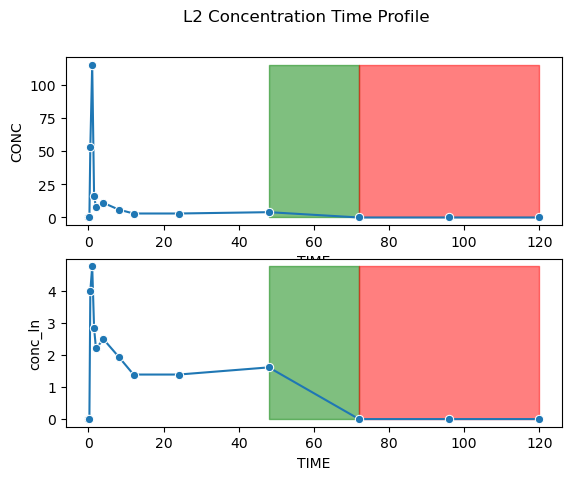

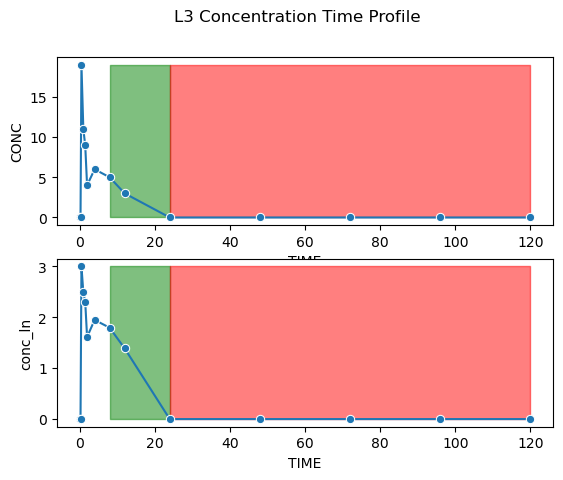

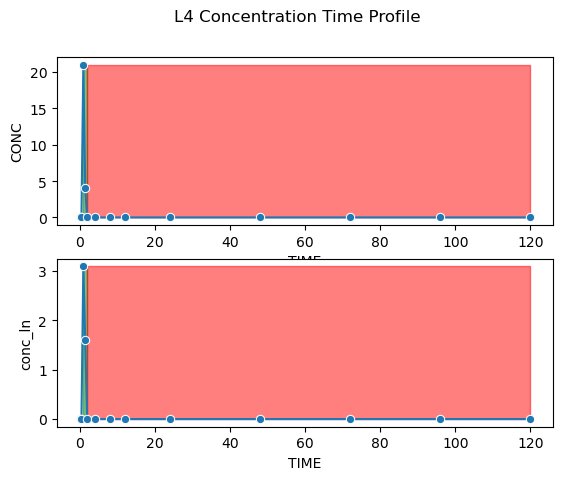

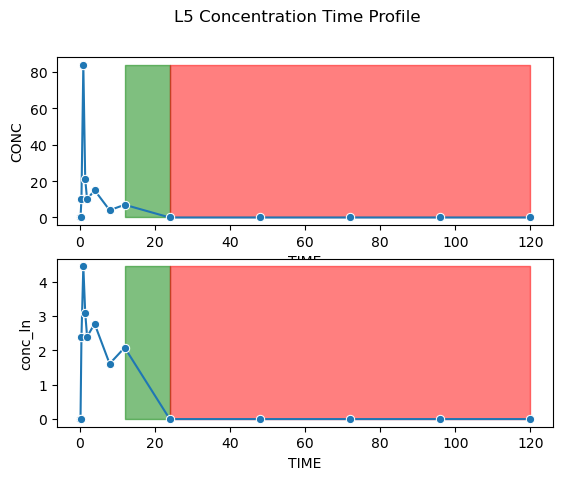

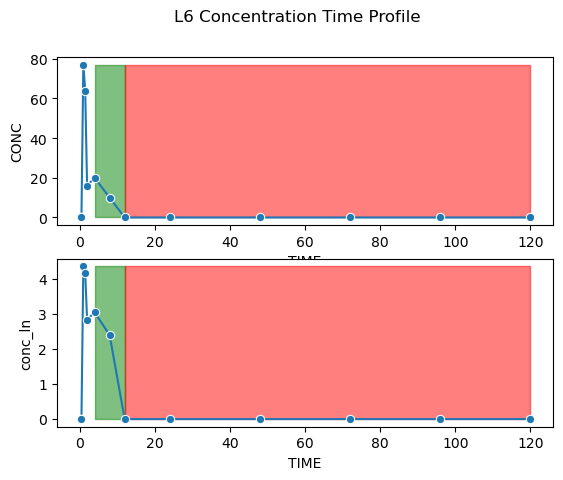

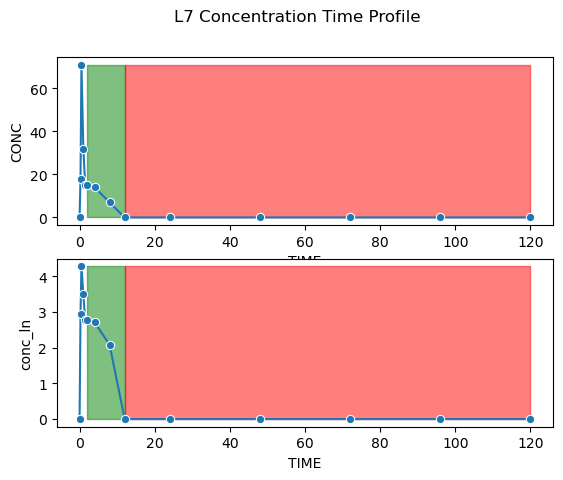

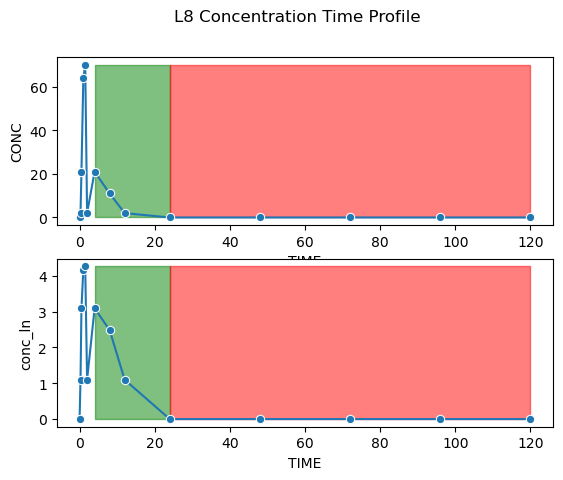

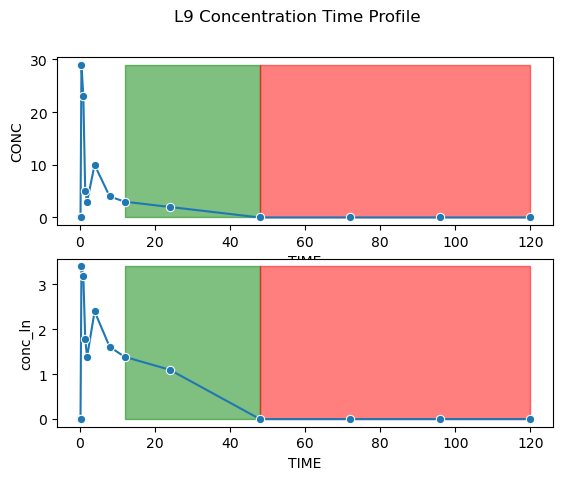

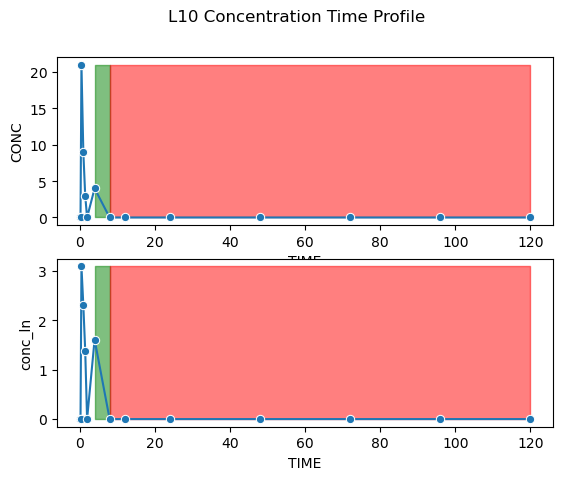

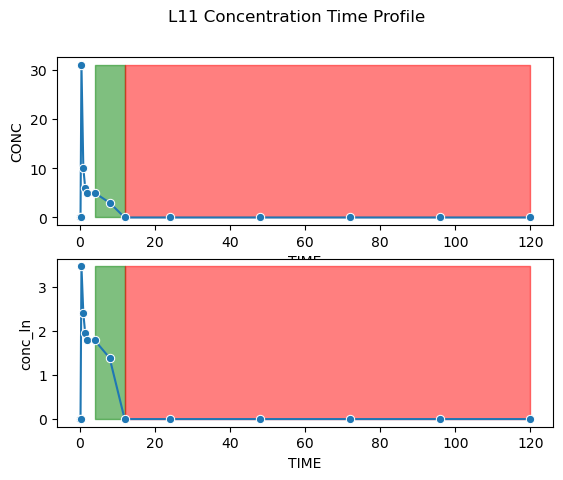

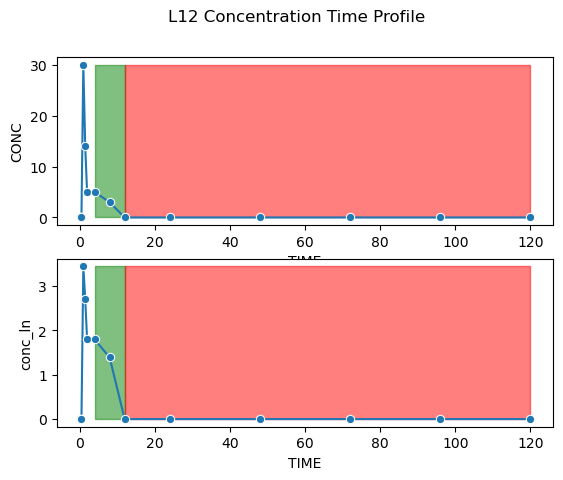

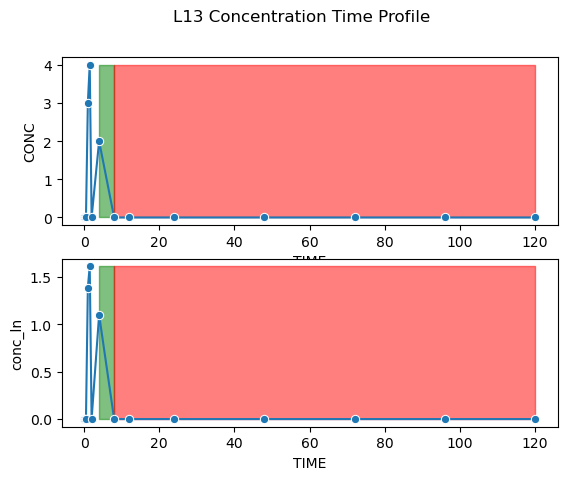

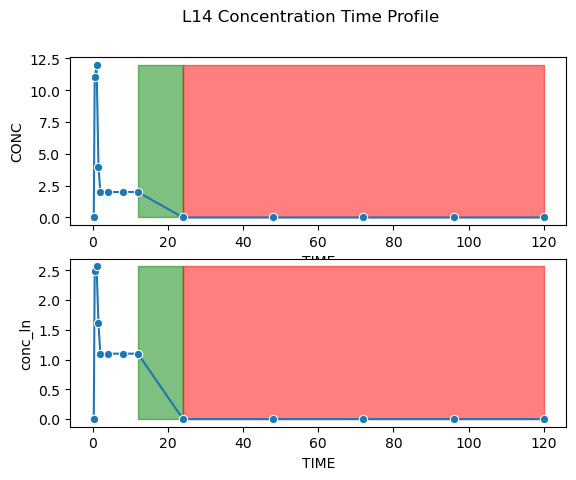

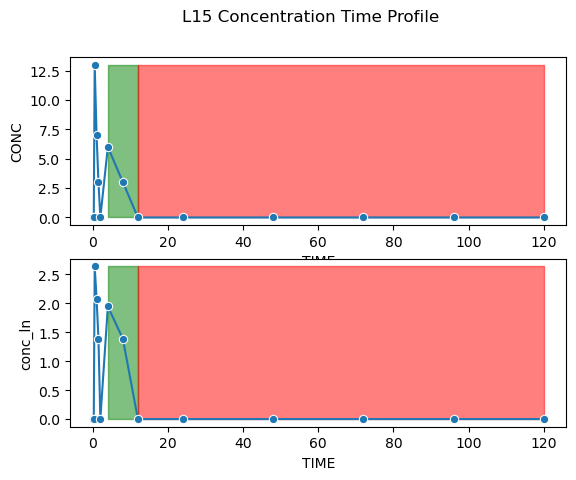

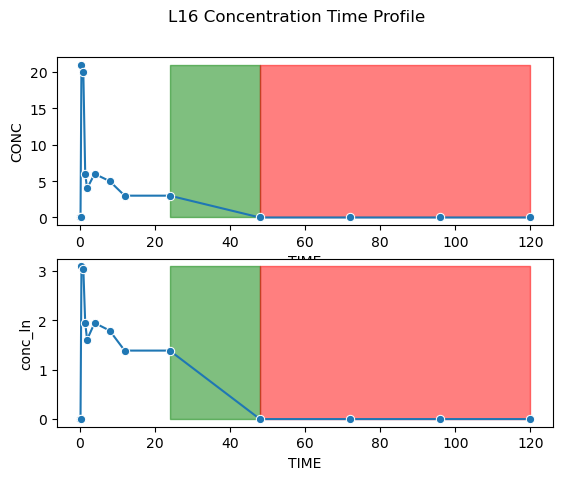

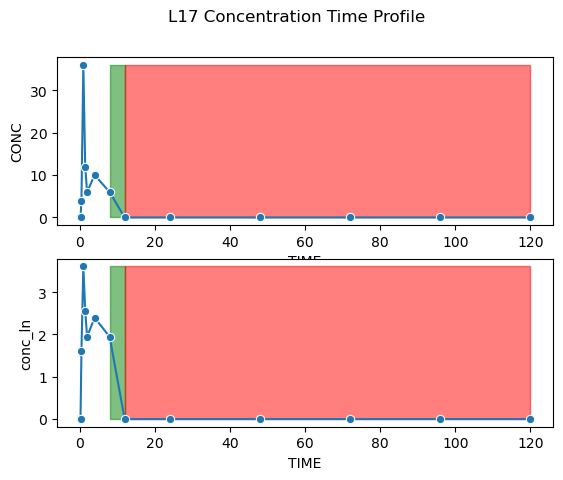

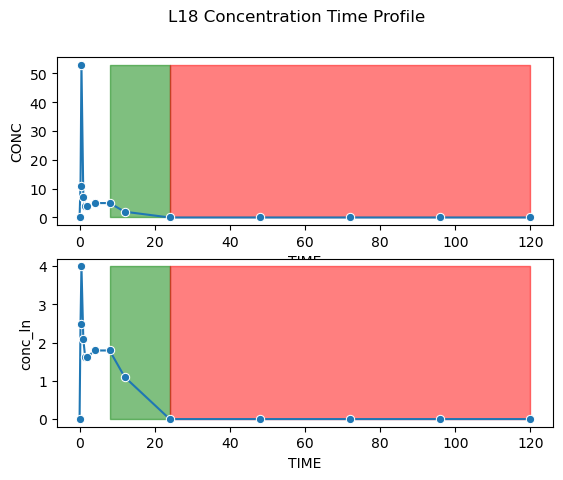

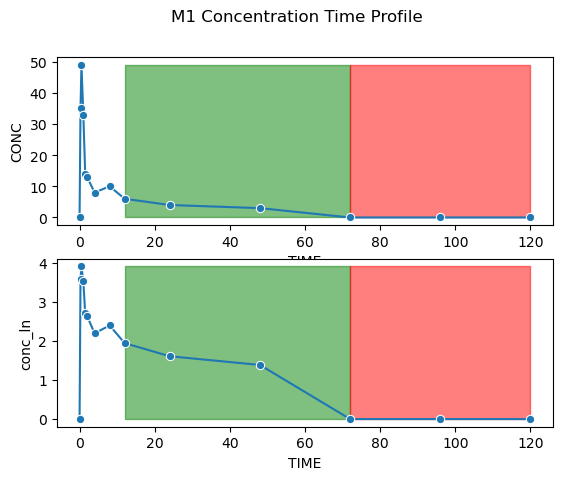

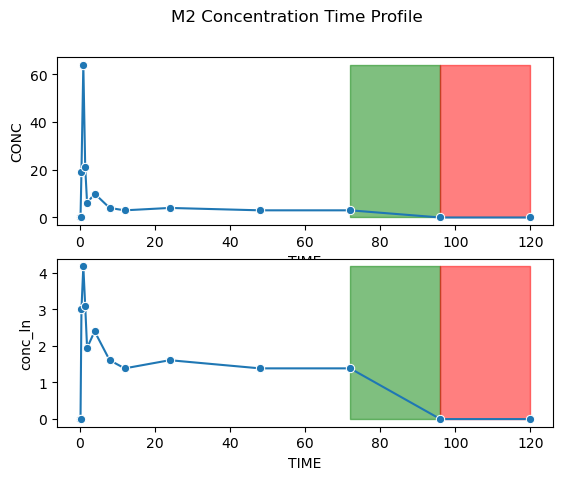

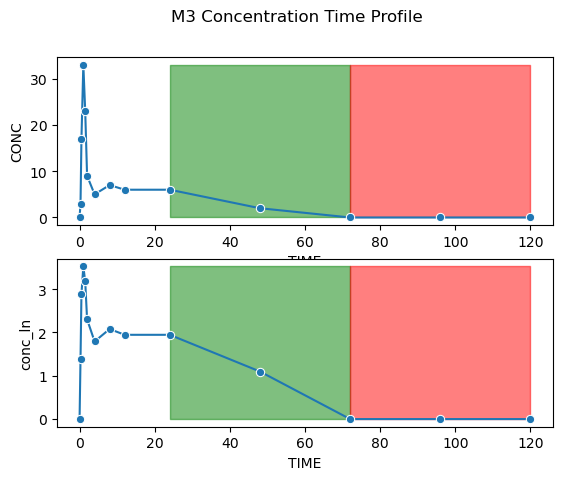

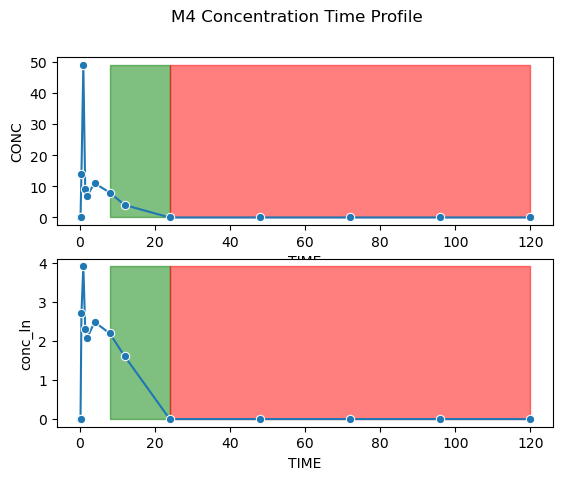

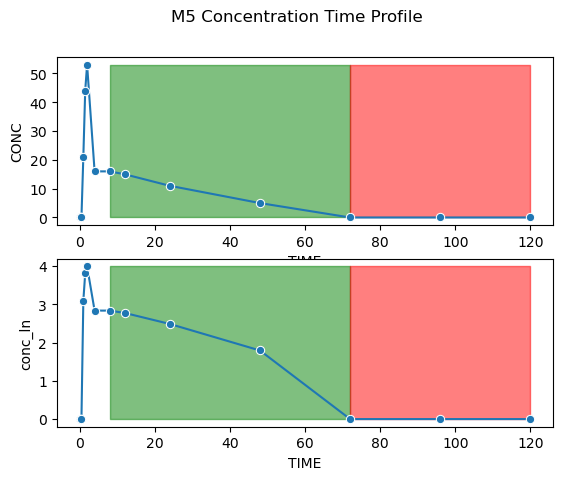

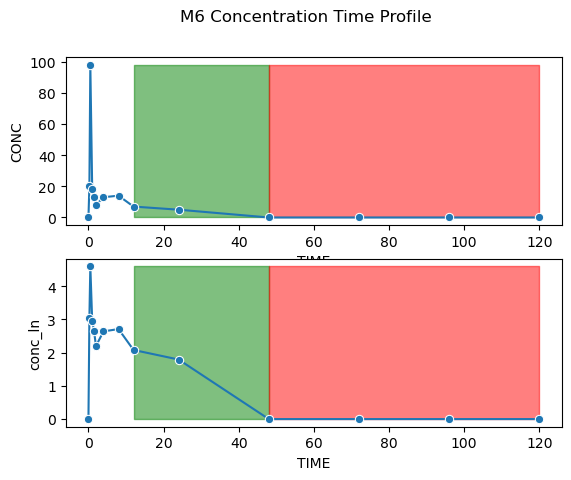

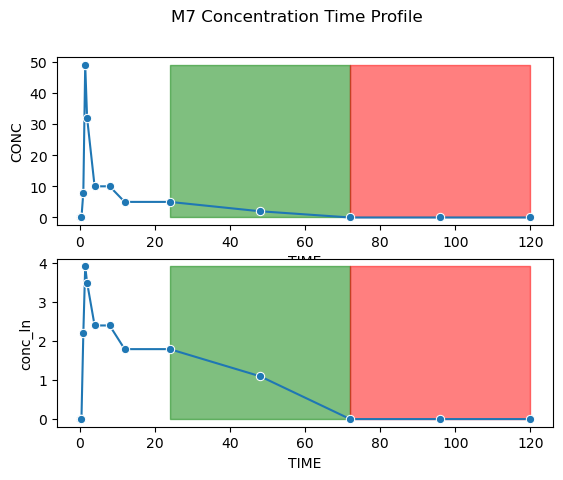

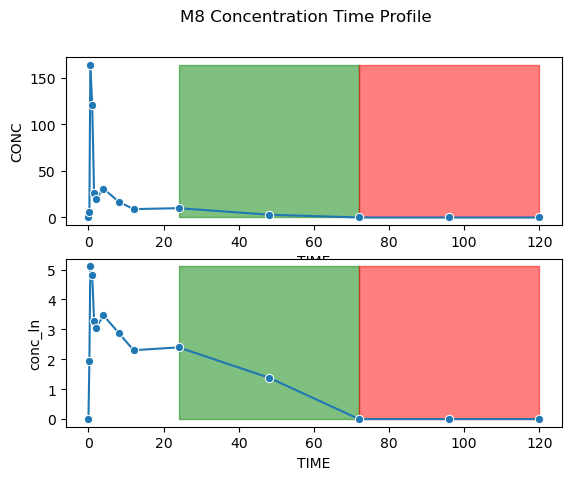

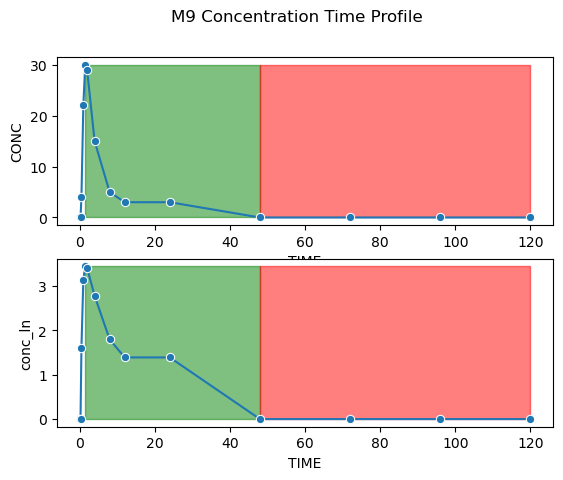

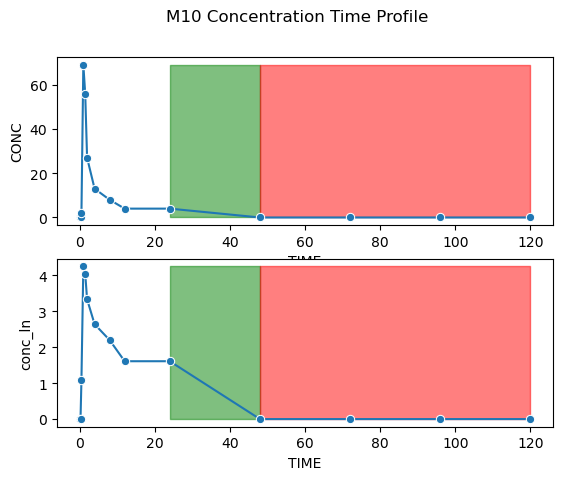

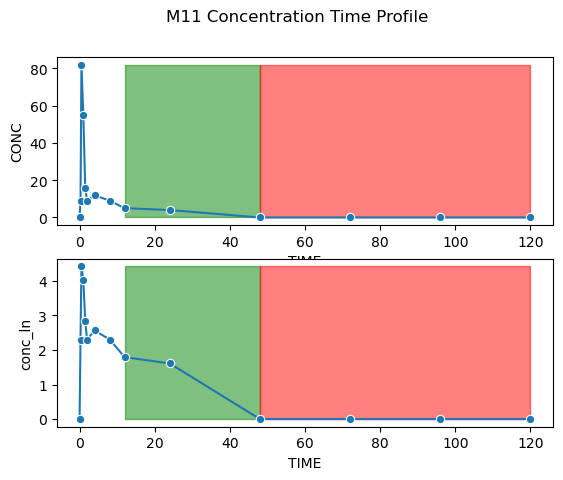

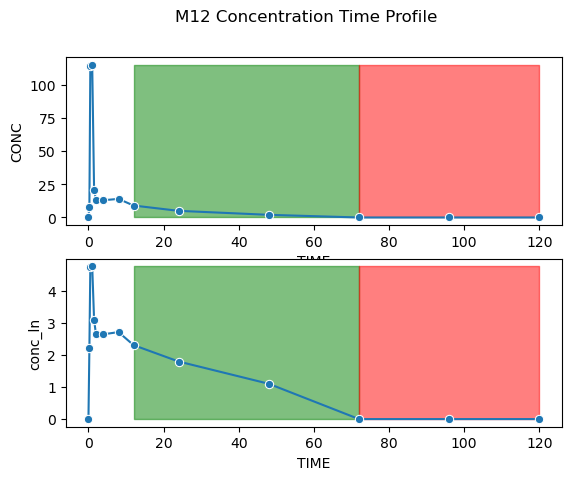

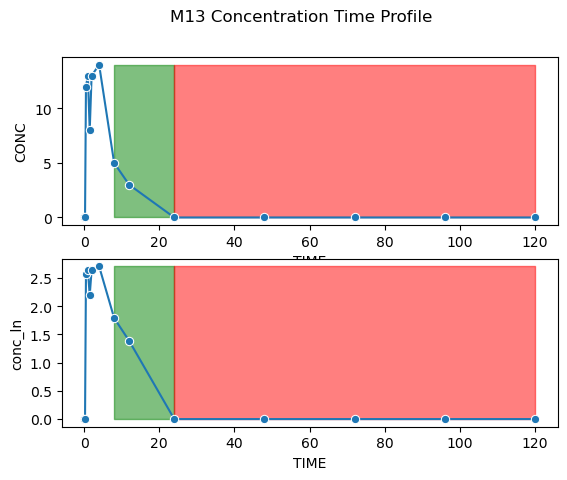

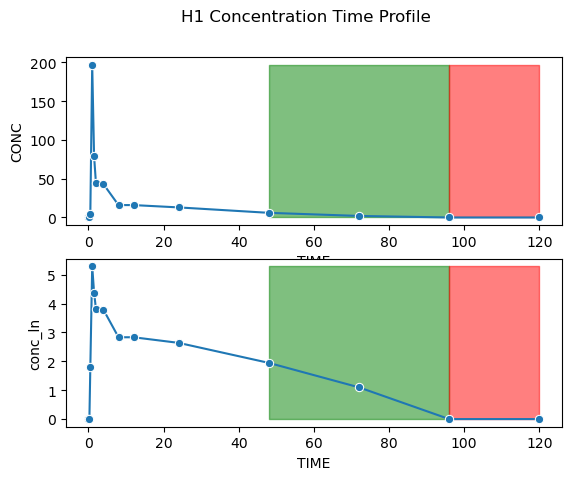

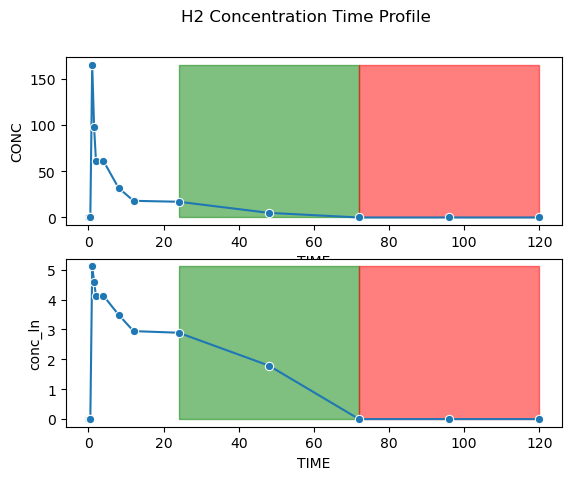

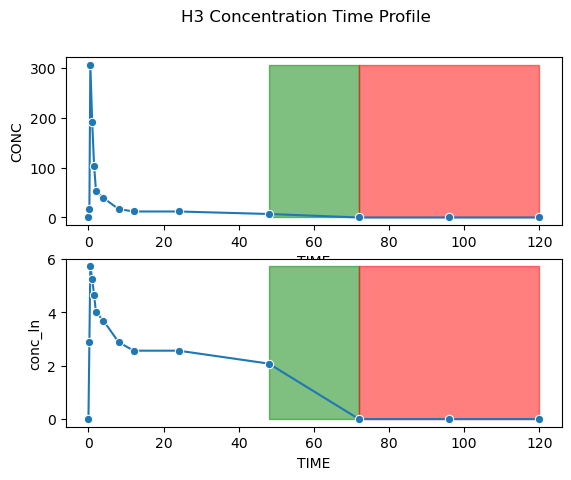

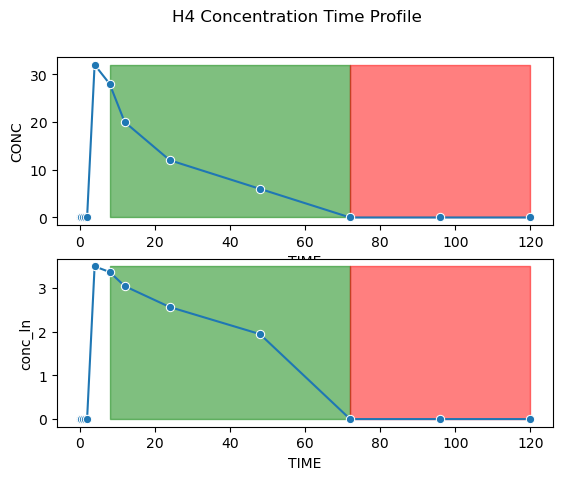

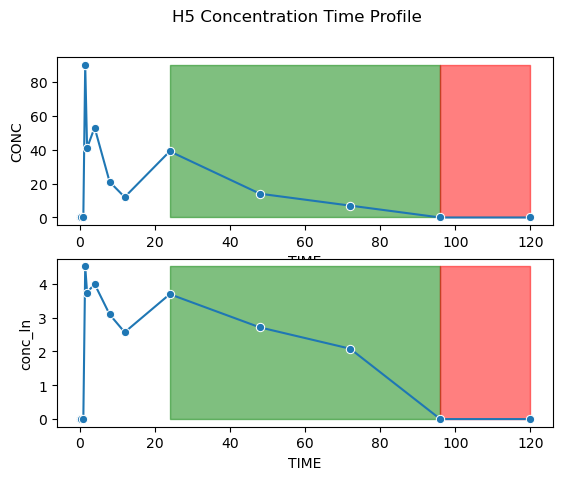

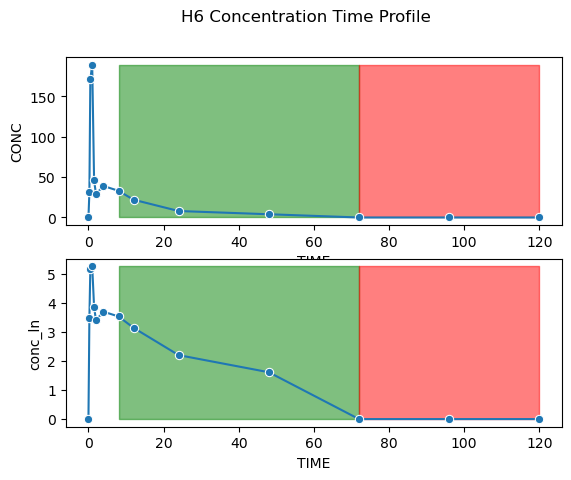

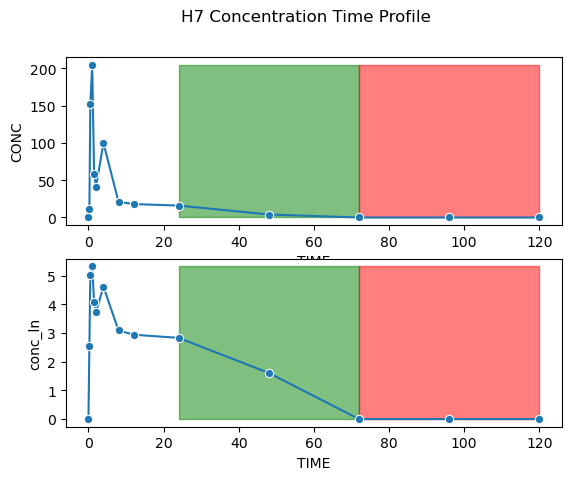

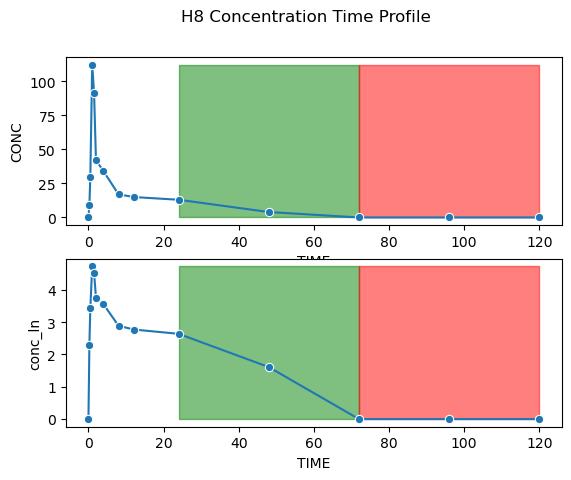

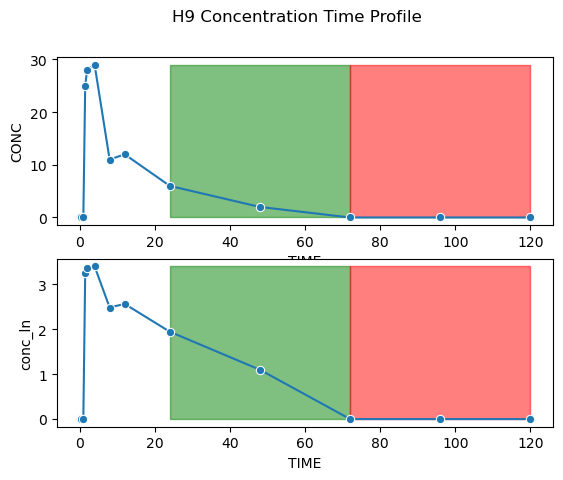

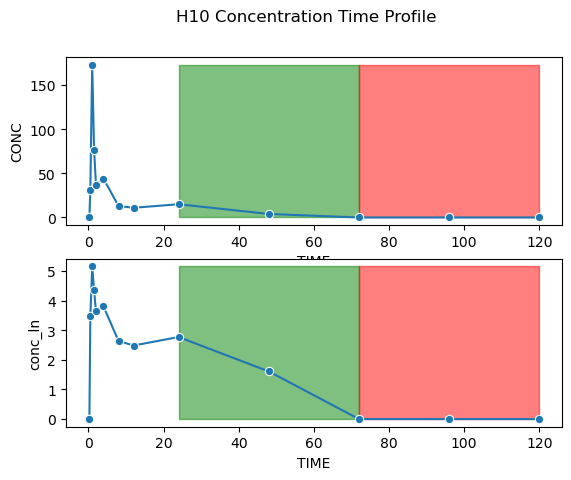

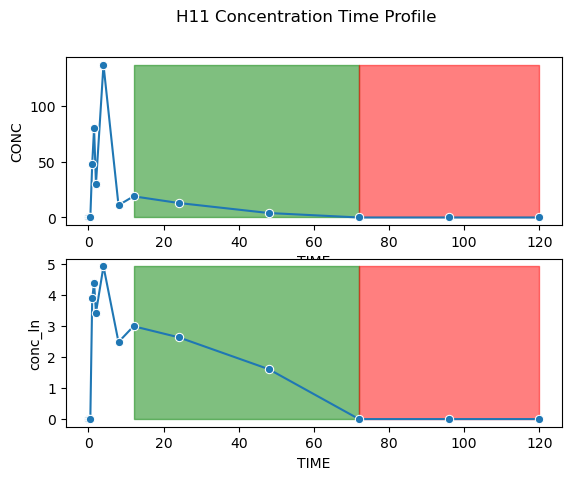

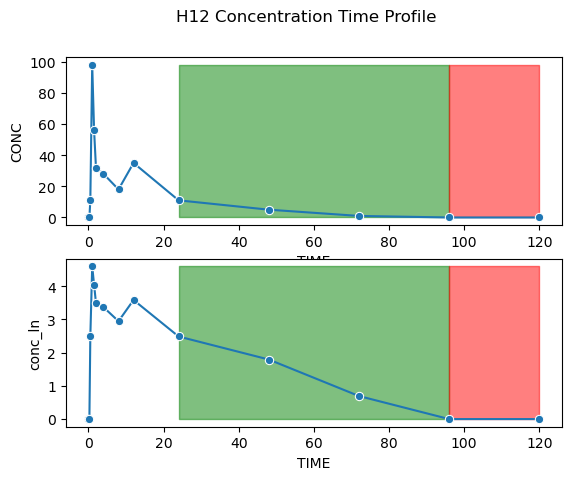

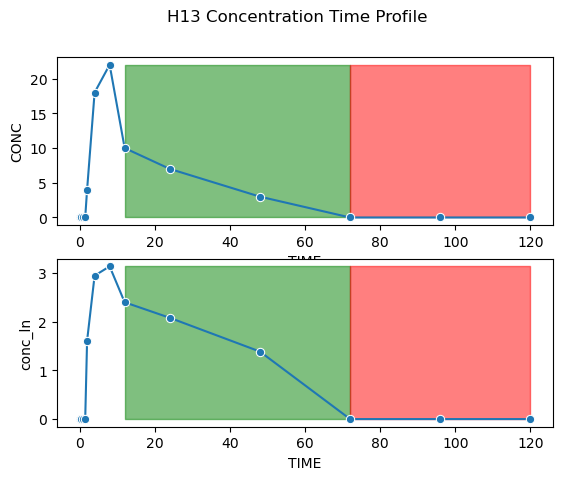

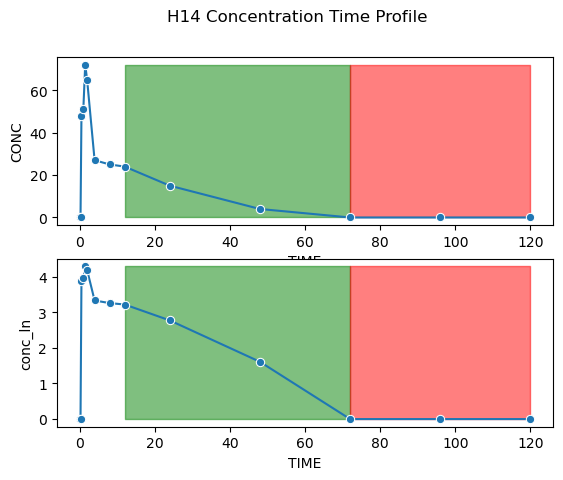

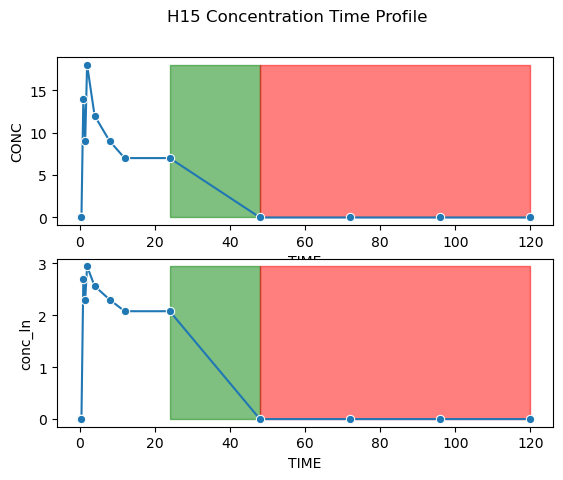

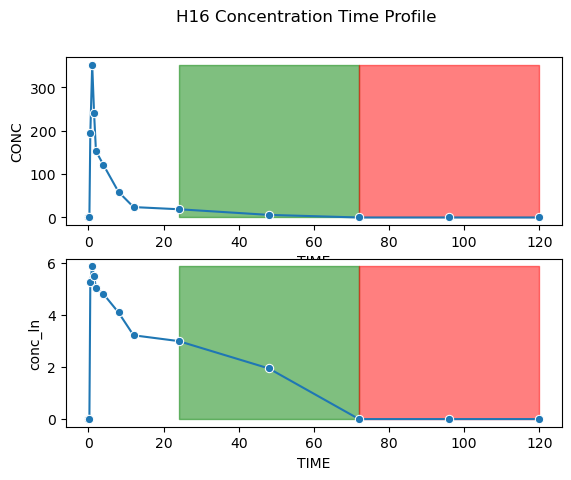

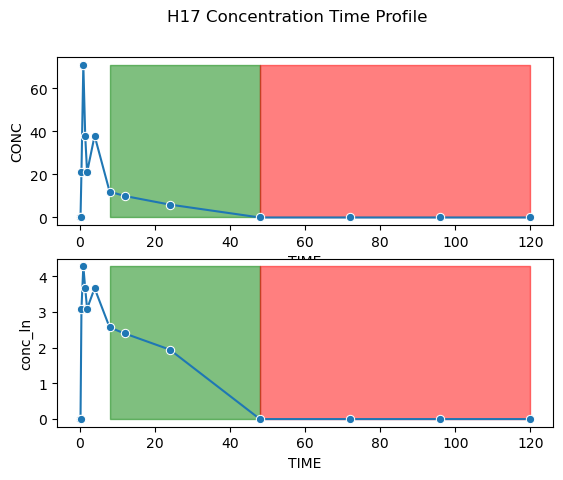

In [23]:
import seaborn as sns
from utils import safe_signed_log
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import os

plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.makedirs('plots')

for id in xth_df['ID'].unique():
    fig, axs = plt.subplots(2)
    plot_me = xth_df.loc[(xth_df['ID'] == id) & (xth_df['TIME'] < 200), :].copy()
    info_df = ks.loc[ks['ID'] == id, ]
    plot_me['conc_ln'] = safe_signed_log(plot_me['CONC'])
    sns.lineplot(plot_me, x = 'TIME', y = 'CONC',ax = axs[0], marker='o')
    y_max = plot_me['CONC'].max()
    y_max_ln = plot_me['conc_ln'].max() 
    terminal_slope_start = info_df['start_time'].values[0]
    terminal_slope_end = info_df['end_time'].max()
    x_max = plot_me['TIME'].max()
    zero_zone_start = info_df['zero_window_time_start'].values[0]
    axs[0].fill_betweenx(y = np.linspace(0, y_max, 5),
                        x1 = np.repeat(terminal_slope_start, 5),
                        x2 = np.repeat(terminal_slope_end, 5),
                        alpha = .5, color = 'green',
                        label = 'Terminal Slope Zone'
                        )
    axs[0].fill_betweenx(y = np.linspace(0, y_max, 5),
                        x1 = np.repeat(zero_zone_start, 5),
                        x2 = np.repeat(x_max, 5),
                        alpha = .5, color = 'red',
                        label = '~0 AUC Zone'
                        )
    sns.lineplot(plot_me, x = 'TIME', y = 'conc_ln',ax = axs[1], marker = 'o')
    axs[1].fill_betweenx(y = np.linspace(0, y_max_ln, 5),
                        x1 = np.repeat(terminal_slope_start, 5),
                        x2 = np.repeat(terminal_slope_end, 5),
                        alpha = .5, color = 'green',
                        label = 'Terminal Slope Zone'
                        )
    axs[1].fill_betweenx(y = np.linspace(0, y_max_ln, 5),
                        x1 = np.repeat(zero_zone_start, 5),
                        x2 = np.repeat(x_max, 5),
                        alpha = .5, color = 'red',
                        label = '~0 AUC Zone'
                        )
    plt.suptitle(f'{id} Concentration Time Profile')
    
    plt.savefig(os.path.join(plot_dir, f'{id}_conctime_new.png'), dpi = 300)


<Axes: xlabel='TIME', ylabel='CONC'>

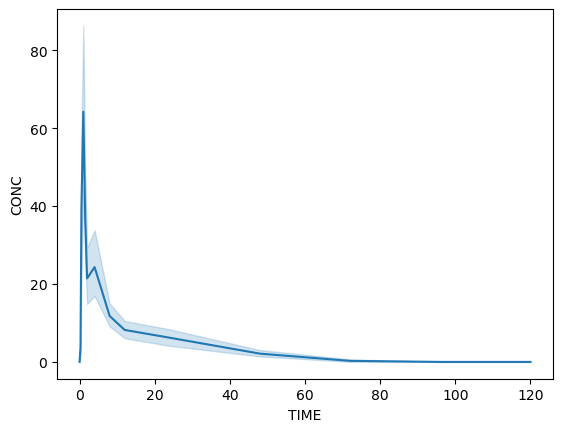

In [24]:
import seaborn as sns


sns.lineplot(xth_df, x = 'TIME', y = 'CONC',)

# MRT

In [25]:
from sklearn.metrics import auc

In [26]:
xth_df['ConcTime'] = xth_df['CONC'] * xth_df['TIME']

<Axes: xlabel='TIME', ylabel='ConcTime'>

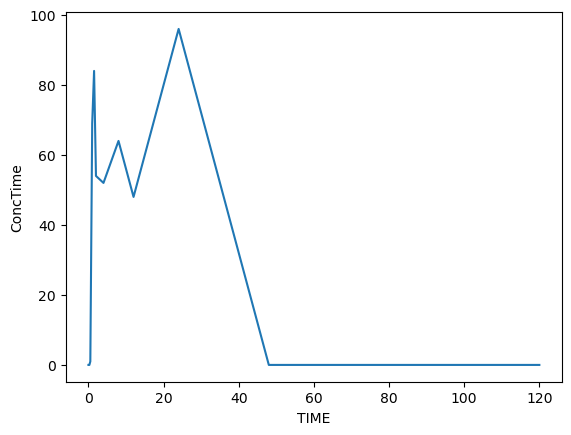

In [27]:
plot_me = xth_df.loc[(xth_df['ID'] == 'M10') & (xth_df['TIME'] < 200), :].copy()
sns.lineplot(plot_me, x = 'TIME', y = 'ConcTime',)

In [28]:
auc_df = (xth_df
 .groupby('ID')[['TIME', 'CONC']]
 .apply(lambda x: auc(x['TIME'], x['CONC']))
 .reset_index()
 .rename(columns = {0:'AUC'})
 )

auc_df.head()


,ID,AUC
0,H1,941.875
1,H10,820.875
2,H11,1038.500
3,H12,899.125
4,H13,425.000


In [29]:
zero_starts

,ID,zero_window_time_start,consecutive_zero_windows
0,L1,24.0,4
1,L2,72.0,2
2,L3,24.0,4
3,L4,2.0,8
4,L5,24.0,4
5,L6,12.0,5
6,L7,12.0,5
7,L8,24.0,4
8,L9,48.0,3
9,L10,8.0,6


In [30]:
auc_calc_df = xth_df.merge(zero_starts, how = 'left', on = 'ID').merge(ks, how = 'left', on = 'ID').copy()

In [31]:
xth_df.shape

(672, 8)

In [32]:
auc_calc_df

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex,ConcTime,zero_window_time_start_x,consecutive_zero_windows_x,...,start_time_mean_abs_cv,start_time_std_mean_cv,auc_per_time_gt_lim,zero_window_time_start_y,consecutive_zero_windows_y,startidx_avg_slope_sign,startidx_avg_adj_r2,method,window_k_est,window_halflife_est
0,L1,0.00,0,xanthohumol,20.0,oral,M,0.0,24.0,4,...,0.839639,0.227279,1.0,24.0,4,-1.0,NaN,final_nonzero_section,0.149313,4.641248
1,L1,0.25,0,xanthohumol,NaN,NaN,M,0.0,24.0,4,...,0.839639,0.227279,1.0,24.0,4,-1.0,NaN,final_nonzero_section,0.149313,4.641248
2,L1,0.50,0,xanthohumol,NaN,NaN,M,0.0,24.0,4,...,0.839639,0.227279,1.0,24.0,4,-1.0,NaN,final_nonzero_section,0.149313,4.641248
3,L1,1.00,34,xanthohumol,NaN,NaN,M,34.0,24.0,4,...,0.839639,0.227279,1.0,24.0,4,-1.0,NaN,final_nonzero_section,0.149313,4.641248
4,L1,1.50,15,xanthohumol,NaN,NaN,M,22.5,24.0,4,...,0.839639,0.227279,1.0,24.0,4,-1.0,NaN,final_nonzero_section,0.149313,4.641248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,H17,24.00,6,xanthohumol,NaN,NaN,M,144.0,48.0,3,...,0.208399,0.098417,1.0,48.0,3,-1.0,0.979525,adj_r2,0.064717,10.708117
668,H17,48.00,0,xanthohumol,NaN,NaN,M,0.0,48.0,3,...,0.208399,0.098417,1.0,48.0,3,-1.0,0.979525,adj_r2,0.064717,10.708117
669,H17,72.00,0,xanthohumol,NaN,NaN,M,0.0,48.0,3,...,0.208399,0.098417,1.0,48.0,3,-1.0,0.979525,adj_r2,0.064717,10.708117
670,H17,96.00,0,xanthohumol,NaN,NaN,M,0.0,48.0,3,...,0.208399,0.098417,1.0,48.0,3,-1.0,0.979525,adj_r2,0.064717,10.708117


In [33]:
from nca import calculate_aucs, extend_auc_to_inf, extend_aumc_to_inf
debugging_tmp = False
auc_df = []
aumc_df = []
for sub in auc_calc_df['ID'].unique():
    
        #orig_settings = np.seterr(all='raise')
    work_df = auc_calc_df.loc[auc_calc_df['ID'] == sub, :].copy()
    conc = work_df['CONC'].values
    time = work_df['TIME'].values
    zero_start = work_df['zero_window_time_start_x'].unique()[0]
    terminal_k = work_df['window_k_est'].unique()[0]
    if sub == 'M10':
        debugging_tmp = True
        debug_vars = {}
        debug_vars['conc'] = np.copy(conc)
        debug_vars['time'] = np.copy(time)
        debug_vars['zero_start'] = np.copy(zero_start)
        debug_vars['terminal_k'] = np.copy(terminal_k)
    aucs = calculate_aucs(time,conc , zero_start, terminal_k)
    auc_inf = extend_auc_to_inf(time, conc, zero_start, terminal_k)
    aucs = pd.concat([aucs, auc_inf]).sort_values(by = 'time_start')
    aucs['zero_window_time_start'] = zero_start
    aucs['terminal_k'] = terminal_k
    #if debugging_tmp:
        #np.seterr(**orig_settings) 
    aucs['ID'] = sub
    conctime = time * conc
    aumcs = calculate_aucs(time, conctime, zero_start, terminal_k, )
    #aumc_inf = extend_aumc_to_inf(work_df['TIME'].values, work_df['ConcTime'].values, zero_start, terminal_k)
    aumc_inf = extend_aumc_to_inf(time, conc, zero_start, terminal_k)
    aumcs = pd.concat([aumcs, aumc_inf]).sort_values(by = 'time_start')
    aumcs['zero_window_time_start'] = zero_start
    aumcs['terminal_k'] = terminal_k
    aumcs['ID'] = sub
    auc_df.append(aucs)
    aumc_df.append(aumcs)
auc_df = pd.concat(auc_df).reset_index(drop = True)
aumc_df = pd.concat(aumc_df).reset_index(drop = True)
#auc_df = auc_df.merge(aucmc_df, how = 'left', on = 'ID')

In [34]:
auc_df

,time_start,time_end,conc_start,conc_end,section_auc_log_trap,section_auc,section_slope_is_pos,linup_logdown,logup_lindown,linear_auc,log_auc,zero_window_time_start,terminal_k,ID
0,0.00,0.25,0,0.0,0.000000,0.000000,False,75.733440,69.443742,72.000,73.177182,24.0,0.149313,L1
1,0.25,0.50,0,0.0,0.000000,0.000000,False,75.733440,69.443742,72.000,73.177182,24.0,0.149313,L1
2,0.50,1.00,0,34.0,4.781529,8.500000,True,75.733440,69.443742,72.000,73.177182,24.0,0.149313,L1
3,1.00,1.50,34,15.0,12.136553,12.250000,False,75.733440,69.443742,72.000,73.177182,24.0,0.149313,L1
4,1.50,2.00,15,6.0,5.443470,5.250000,False,75.733440,69.443742,72.000,73.177182,24.0,0.149313,L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,24.00,48.00,6,0.0,74.001361,72.000000,False,449.136989,436.171060,438.625,446.683049,48.0,0.064717,H17
668,24.00,inf,6,0.0,92.710969,92.710969,False,NaN,NaN,NaN,NaN,48.0,0.064717,H17
669,48.00,72.00,0,0.0,0.000000,0.000000,False,449.136989,436.171060,438.625,446.683049,48.0,0.064717,H17
670,72.00,96.00,0,0.0,0.000000,0.000000,False,449.136989,436.171060,438.625,446.683049,48.0,0.064717,H17


In [36]:
f1 = aumc_df['time_start'] < aumc_df['zero_window_time_start']
f2 = aumc_df['time_end'] < aumc_df['zero_window_time_start']
f3 = (aumc_df['time_start'] < aumc_df['zero_window_time_start']) & (aumc_df['time_end'] == np.inf)
tmp = aumc_df.loc[(f1 & f2) | f3, :].copy()
aumcs_res = tmp.groupby('ID')[['section_auc_log_trap', 'section_auc']].sum().reset_index()

In [ ]:
f1 = auc_df['time_start'] < auc_df['zero_window_time_start']
f2 = auc_df['time_end'] < auc_df['zero_window_time_start']
f3 = (auc_df['time_start'] < auc_df['zero_window_time_start']) & (auc_df['time_end'] == np.inf)
tmp = auc_df.loc[(f1 & f2) | f3, :].copy()
linear_only_auc = (tmp
                   .groupby('ID')[['section_auc']]
                   .sum()
                   .reset_index()
                   .rename(columns = {'section_auc':'linear_auc'})
                   
                   )
tmp_up = tmp.loc[tmp['section_slope_is_pos']]
linear_up = tmp_up.groupby('ID')['section_auc'].sum().reset_index()
tmp_down = tmp.loc[~tmp['section_slope_is_pos']]
log_down = tmp_down.groupby('ID')['section_auc_log_trap'].sum().reset_index()
tmp = linear_up.merge(log_down, how = 'left', on = 'ID')
tmp['linup_logdown_auc'] = tmp['section_auc'] + tmp['section_auc_log_trap']
auc_res = tmp.merge(linear_only_auc, how = 'left', on = 'ID')

In [63]:
nca_df = pd.read_csv(r'/workspaces/miniconda/PKdata/data/xanthohumol_nca.csv')
#mrt_df = nca_df.loc[nca_df['Parameter'] == 'AUC']
mrt_df = nca_df.loc[nca_df['ANALYTE'] == 'xanthohumol', :]

In [ ]:
mrt_df = mrt_df.pivot_table(index = ['ID', 'Software'],columns = 'Parameter', values = 'Value').reset_index()

In [65]:
plot_me = mrt_df.merge(auc_res[['ID', 'linup_logdown_auc', 'linear_auc']], how = 'left', on = 'ID')

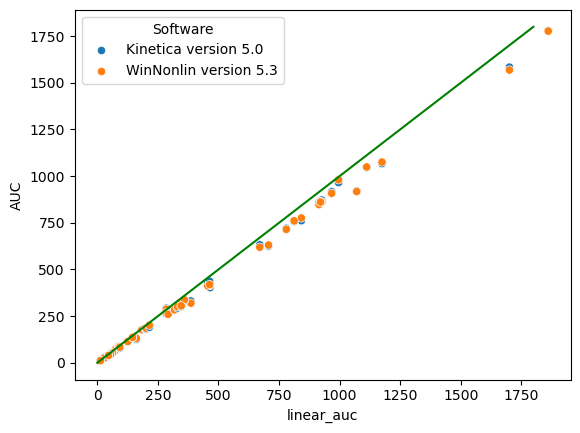

In [67]:
import matplotlib.pyplot as plt

sns.scatterplot(plot_me, x = 'linear_auc', y = 'AUC', hue = 'Software')
plt.plot(np.linspace(0,1800, 10), np.linspace(0,1800, 10), color = 'green')

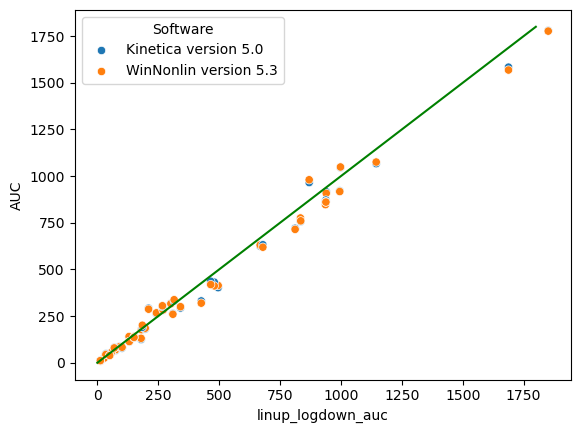

In [69]:
sns.scatterplot(plot_me, x = 'linup_logdown_auc', y = 'AUC', hue = 'Software')
plt.plot(np.linspace(0,1800, 10), np.linspace(0,1800, 10), color = 'green')

In [44]:
plot_me = mrt_df.merge(aumc_df[['ID', 'linup_logdown', 'linear_auc']], how = 'left', on = 'ID')

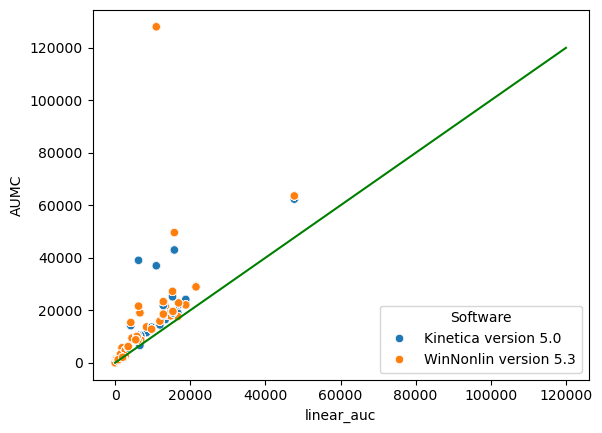

In [45]:
sns.scatterplot(plot_me, x = 'linear_auc', y = 'AUMC', hue = 'Software')
plt.plot(np.linspace(0,120000, 10), np.linspace(0,120000, 10), color = 'green')

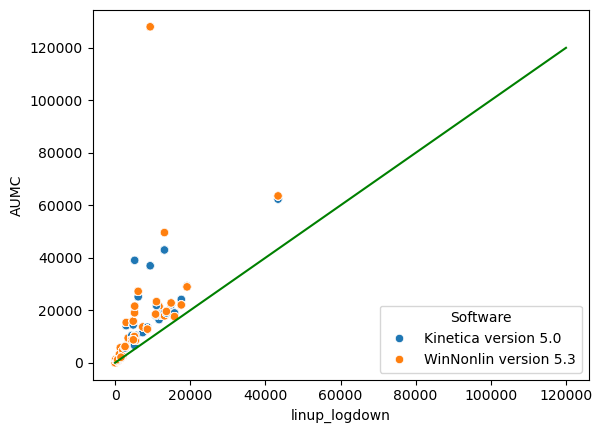

In [46]:
sns.scatterplot(plot_me, x = 'linup_logdown', y = 'AUMC', hue = 'Software')
plt.plot(np.linspace(0,120000, 10), np.linspace(0,120000, 10), color = 'green')

# CL/F

In [54]:
clf_df = xth_df.merge(aucs_res, how = 'left', on = 'ID')

In [55]:
clf_df

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex,ConcTime,section_auc_log_trap,section_auc
0,L1,0.00,0,xanthohumol,20.0,oral,M,0.0,73.177182,75.486638
1,L1,0.25,0,xanthohumol,NaN,NaN,M,0.0,73.177182,75.486638
2,L1,0.50,0,xanthohumol,NaN,NaN,M,0.0,73.177182,75.486638
3,L1,1.00,34,xanthohumol,NaN,NaN,M,34.0,73.177182,75.486638
4,L1,1.50,15,xanthohumol,NaN,NaN,M,22.5,73.177182,75.486638
...,...,...,...,...,...,...,...,...,...,...
667,H17,24.00,6,xanthohumol,NaN,NaN,M,144.0,465.392656,459.335969
668,H17,48.00,0,xanthohumol,NaN,NaN,M,0.0,465.392656,459.335969
669,H17,72.00,0,xanthohumol,NaN,NaN,M,0.0,465.392656,459.335969
670,H17,96.00,0,xanthohumol,NaN,NaN,M,0.0,465.392656,459.335969


In [70]:
auc_df

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex,ConcTime,time_start,time_end,...,conc_end,section_auc_log_trap,section_auc,section_conc_change_sign,linup_logdown,logup_lindown,linear_auc,log_auc,zero_window_time_start,terminal_k
0,L1,0.0,0,xanthohumol,20.0,oral,M,0.0,0.00,0.25,...,0.0,0.000000,0.000000,False,75.733440,69.443742,72.000,73.177182,24.0,0.149313
1,L1,0.0,0,xanthohumol,20.0,oral,M,0.0,0.25,0.50,...,0.0,0.000000,0.000000,False,75.733440,69.443742,72.000,73.177182,24.0,0.149313
2,L1,0.0,0,xanthohumol,20.0,oral,M,0.0,0.50,1.00,...,34.0,4.781529,8.500000,True,75.733440,69.443742,72.000,73.177182,24.0,0.149313
3,L1,0.0,0,xanthohumol,20.0,oral,M,0.0,1.00,1.50,...,15.0,12.136553,12.250000,False,75.733440,69.443742,72.000,73.177182,24.0,0.149313
4,L1,0.0,0,xanthohumol,20.0,oral,M,0.0,1.50,2.00,...,6.0,5.443470,5.250000,False,75.733440,69.443742,72.000,73.177182,24.0,0.149313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9403,H17,120.0,0,xanthohumol,NaN,NaN,M,0.0,24.00,48.00,...,0.0,74.001361,72.000000,False,449.136989,436.171060,438.625,446.683049,48.0,0.064717
9404,H17,120.0,0,xanthohumol,NaN,NaN,M,0.0,24.00,inf,...,0.0,92.710969,92.710969,False,NaN,NaN,NaN,NaN,48.0,0.064717
9405,H17,120.0,0,xanthohumol,NaN,NaN,M,0.0,48.00,72.00,...,0.0,0.000000,0.000000,False,449.136989,436.171060,438.625,446.683049,48.0,0.064717
9406,H17,120.0,0,xanthohumol,NaN,NaN,M,0.0,72.00,96.00,...,0.0,0.000000,0.000000,False,449.136989,436.171060,438.625,446.683049,48.0,0.064717


In [56]:
clf_df['dose_ug'] = clf_df['DOSE'] * 1000
clf_df['cl/f'] = clf_df['dose_ug']/clf_df['linup_logdown']
clf_df = clf_df[['ID', 'cl/f']].dropna().copy()
clf_df #these are close, but the AUC I was calculating should 

KeyError: 'linup_logdown'